In [1]:
import os
import numpy as np
import trimesh as tm

from pymcfs.mesh import MeshManager, example_mesh
from pymcfs.mcf import mean_curvature_flow
from pymcfs.medial import compute_voronoi_poles
from pymcfs.laplacian import cotangent_laplacian, mean_value_laplacian
from pymcfs.skeleton import thin_mesh, skeletonize, curve_skeleton_from_mesh

import logging
logging.basicConfig(level=logging.INFO)

# mesh = example_mesh("cylinder", radius=1, height=10, sections=32)
mesh = example_mesh("torus", major_radius=1.0, minor_radius=0.3, major_sections=32, minor_sections=8)

In [2]:
mm = MeshManager(mesh)
mm.print_mesh_analysis()
mm.visualize_mesh_3d()


INFO:pymcfs.mesh:Mesh Analysis Report
INFO:pymcfs.mesh:====================
INFO:pymcfs.mesh:
Geometry:
INFO:pymcfs.mesh:  * Vertices: 256
INFO:pymcfs.mesh:  * Faces: 512
INFO:pymcfs.mesh:  * Components: 1
INFO:pymcfs.mesh:  * Volume: 1.59
INFO:pymcfs.mesh:  * Bounds: [-1.3, -1.3, -0.3] to [1.3, 1.3, 0.3]
INFO:pymcfs.mesh:
Mesh Quality:
INFO:pymcfs.mesh:  * Watertight: True
INFO:pymcfs.mesh:  * Winding Consistent: True
INFO:pymcfs.mesh:  * Normal Direction: outward
INFO:pymcfs.mesh:  * Duplicate Vertices: 0
INFO:pymcfs.mesh:  * Degenerate Faces: 0
INFO:pymcfs.mesh:
Topology:
INFO:pymcfs.mesh:  * Genus: 1
INFO:pymcfs.mesh:  * Euler Characteristic: 0
INFO:pymcfs.mesh:
No issues detected
INFO:pymcfs.mesh:
Recommendation:
INFO:pymcfs.mesh:  Mesh appears to be in good condition.
INFO:pymcfs.mesh:====================


In [3]:
V = np.asarray(mesh.vertices)
F = np.asarray(mesh.faces, dtype=int)

# Cotangent Laplacian (robust mode clamps negative cot weights)
L_cot = cotangent_laplacian(V, F, secure=True)
print("Cotangent L: shape=", L_cot.shape, "nnz=", L_cot.nnz)

# Mean-value Laplacian
L_mvl = mean_value_laplacian(V, F)
print("Mean-value L: shape=", L_mvl.shape, "nnz=", L_mvl.nnz)

Cotangent L: shape= (256, 256) nnz= 1792
Mean-value L: shape= (256, 256) nnz= 1792


In [4]:
# Unguided implicit MCF (cotangent, secure weights)
mcf_res = mean_curvature_flow(
    mesh,
    dt=1e-3,
    iterations=300,
    laplacian_type="cotangent",
    laplacian_secure=True,
)

V_after = mcf_res.vertices
mesh_after = tm.Trimesh(vertices=V_after, faces=mesh.faces, process=False)
print("Volume: before=", mesh.volume, " after=", mesh_after.volume)
mm_after = MeshManager(mesh_after)
mm_after.visualize_mesh_3d()

Volume: before= 1.5891804246697518  after= 0.006286035446844755


In [5]:
# "original" guidance pulls vertices back towards the initial shape during flow
mcf_guided = mean_curvature_flow(
    mesh,
    dt=2e-3,
    iterations=5000,
    laplacian_type="cotangent",
    laplacian_secure=True,
    guidance_type="original",
    guidance_weight=0.1,  # increase to preserve more shape
)

V_guid = mcf_guided.vertices
mesh_guid = tm.Trimesh(vertices=V_guid, faces=mesh.faces, process=False)
print("Volume (guided): before=", mesh.volume, " after=", mesh_guid.volume)
mm_guid = MeshManager(mesh_guid)
mm_guid.visualize_mesh_3d()

Volume (guided): before= 1.5891804246697518  after= 1.5544587248686714


In [6]:
# Compute per-vertex medial targets and weights
targets, weights = compute_voronoi_poles(mesh)  # targets: (n,3), weights in [0,1]
print("Voronoi targets/weights:", targets.shape, weights.shape)

# Run MCF with per-vertex diagonal guidance
mcf_medial = mean_curvature_flow(
    mesh,
    dt=1e-2,
    iterations=10,
    laplacian_type="cotangent",
    laplacian_secure=True,
    guidance_targets=targets,
    guidance_diag=weights * 0.5,  # scale weights for overall effect
)
V_medial = mcf_medial.vertices

Voronoi targets/weights: (256, 3) (256,)


In [7]:
V_thin, F_thin = thin_mesh(
    mesh,
    mcf_dt=2e-2,
    mcf_iters=30,
    laplacian_type="cotangent",
    guidance_type=None,       # or "voronoi" with guidance_weight>0 for medial protection
    guidance_weight=0.0,
    collapse_passes=2,
    collapse_percentile=0.3,
    preserve_branch_degree=3,
    collapse_mode="percentile",  # or "pq" / "pq_heap"
    collapse_ratio=0.1,
    medial_protect=False,     # set True with "voronoi" to protect near-pole edges
    medial_protect_threshold=0.5,
    verbose=False,
)
print("Thinned mesh V/F:", V_thin.shape, F_thin.shape)

Thinned mesh V/F: (256, 3) (512, 3)


Contracted mesh edges: 768
Edge length stats: min=0.004732, max=0.075210, mean=0.051195
Edge length percentiles: 25%=0.014941, 50%=0.069696, 75%=0.072665
Threshold at 10 percentile: 0.004732 (affects 1 edges)
Threshold at 30 percentile: 0.004732 (affects 3 edges)
Threshold at 50 percentile: 0.004732 (affects 4 edges)
Threshold at 70 percentile: 0.004732 (affects 6 edges)
Threshold at 90 percentile: 0.004732 (affects 7 edges)


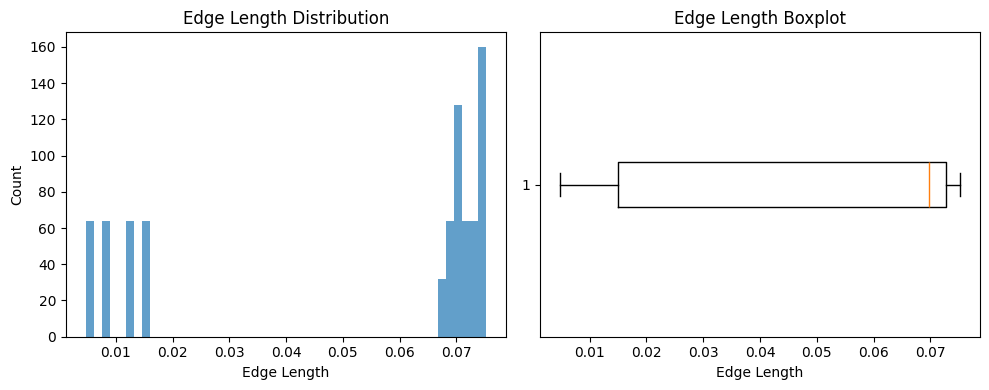

In [8]:
# DEBUG: Analyze edge length distributions before skeletonization
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# First run MCF to get contracted mesh
mcf_debug = mean_curvature_flow(
    mesh,
    dt=2e-2,
    iterations=50,
    laplacian_type="cotangent",
    laplacian_secure=True,
    guidance_type=None,
)

V_contracted = mcf_debug.vertices
mesh_contracted = tm.Trimesh(vertices=V_contracted, faces=mesh.faces, process=False)

# Analyze edge lengths on contracted mesh
edges = mesh_contracted.edges_unique
edge_lengths = np.linalg.norm(V_contracted[edges[:, 0]] - V_contracted[edges[:, 1]], axis=1)

print(f"Contracted mesh edges: {len(edges)}")
print(f"Edge length stats: min={edge_lengths.min():.6f}, max={edge_lengths.max():.6f}, mean={edge_lengths.mean():.6f}")
print(f"Edge length percentiles: 25%={np.percentile(edge_lengths, 25):.6f}, 50%={np.percentile(edge_lengths, 50):.6f}, 75%={np.percentile(edge_lengths, 75):.6f}")

# Test different collapse thresholds
test_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
for q in test_thresholds:
    threshold = np.percentile(edge_lengths, q)
    count_below = np.sum(edge_lengths < threshold)
    print(f"Threshold at {q*100:.0f} percentile: {threshold:.6f} (affects {count_below} edges)")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(edge_lengths, bins=50, alpha=0.7)
plt.xlabel('Edge Length')
plt.ylabel('Count')
plt.title('Edge Length Distribution')
plt.subplot(1, 2, 2)
plt.boxplot(edge_lengths, vert=False)
plt.xlabel('Edge Length')
plt.title('Edge Length Boxplot')
plt.tight_layout()
plt.show()

# Visualize contracted mesh
mm_debug = MeshManager(mesh_contracted)
mm_debug.visualize_mesh_3d()


=== Testing Aggressive Percentile (10%) ===
Result: nodes=256, edges=864

=== Testing PQ Mode (30% ratio) ===
Result: nodes=256, edges=864

=== Testing PQ Heap Mode (20% ratio) ===
Result: nodes=256, edges=864

=== Testing Low Degree Preservation (degree 2) ===
Result: nodes=256, edges=864


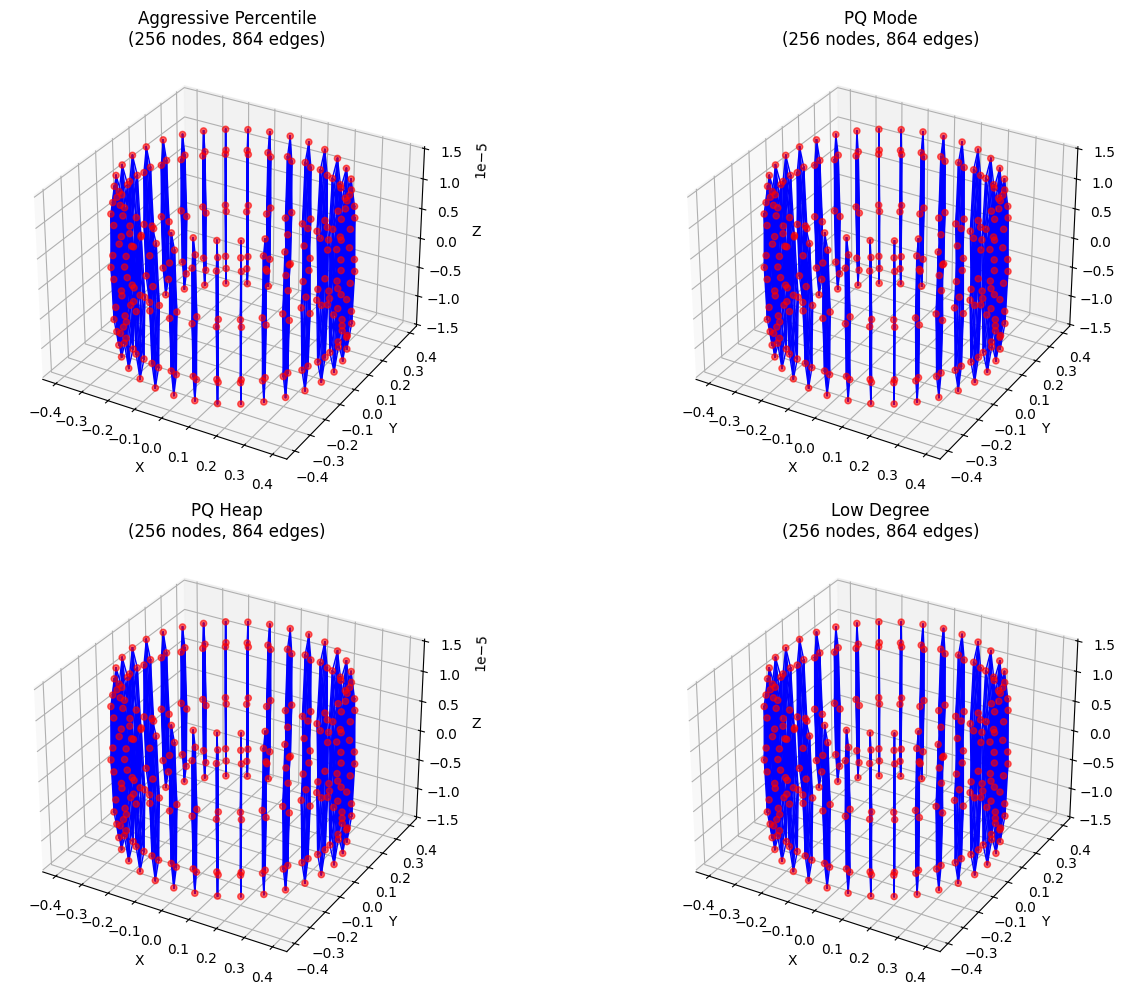

In [9]:
# DEBUG: Test different collapse strategies and parameters
def test_collapse_strategy(params, name):
    print(f"\n=== Testing {name} ===")
    skel_test = skeletonize(
        mesh,
        mcf_dt=2e-2,
        mcf_iters=50,
        laplacian_type="cotangent",
        guidance_type=None,
        build_graph="mesh",
        knn=12,
        length_quantile=0.7,
        collapse_passes=3,
        # preserve_branch_degree=3,
        verbose=False,
        **params
    )
    print(f"Result: nodes={skel_test.nodes.shape[0]}, edges={skel_test.edges.shape[0]}")
    return skel_test

# Test 1: More aggressive percentile threshold
skel_aggressive = test_collapse_strategy({
    'collapse_mode': 'percentile',
    'collapse_percentile': 0.1,  # Much lower threshold
}, 'Aggressive Percentile (10%)')

# Test 2: PQ mode with higher ratio
skel_pq = test_collapse_strategy({
    'collapse_mode': 'pq',
    'collapse_ratio': 0.3,  # Higher collapse ratio
}, 'PQ Mode (30% ratio)')

# Test 3: PQ heap mode
skel_heap = test_collapse_strategy({
    'collapse_mode': 'pq_heap',
    'collapse_ratio': 0.2,
}, 'PQ Heap Mode (20% ratio)')

# Test 4: Lower preserve_branch_degree
skel_low_degree = test_collapse_strategy({
    'collapse_mode': 'percentile',
    'collapse_percentile': 0.2,
    'preserve_branch_degree': 2,  # Allow collapsing at degree-2 nodes
}, 'Low Degree Preservation (degree 2)')

# Visualize comparisons
fig = plt.figure(figsize=(15, 10))
results = [
    (skel_aggressive, 'Aggressive Percentile'),
    (skel_pq, 'PQ Mode'),
    (skel_heap, 'PQ Heap'),
    (skel_low_degree, 'Low Degree')
]

for i, (skel_result, title) in enumerate(results, 1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    # Plot skeleton edges
    for edge in skel_result.edges:
        points = skel_result.nodes[edge]
        ax.plot3D(points[:, 0], points[:, 1], points[:, 2], 'b-', linewidth=1)
    # Plot nodes
    ax.scatter(skel_result.nodes[:, 0], skel_result.nodes[:, 1], skel_result.nodes[:, 2], 
              c='red', s=20, alpha=0.6)
    ax.set_title(f'{title}\n({skel_result.nodes.shape[0]} nodes, {skel_result.edges.shape[0]} edges)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

plt.tight_layout()
plt.show()

=== Testing Different Mesh Types ===

--- Testing Sphere ---
Original mesh: 162 vertices, 320 faces
Result: 162 nodes, 360 edges

--- Testing Cylinder ---
Original mesh: 34 vertices, 64 faces
Result: 34 nodes, 72 edges

--- Testing Cube ---
Original mesh: 8 vertices, 12 faces
Result: 8 nodes, 18 edges


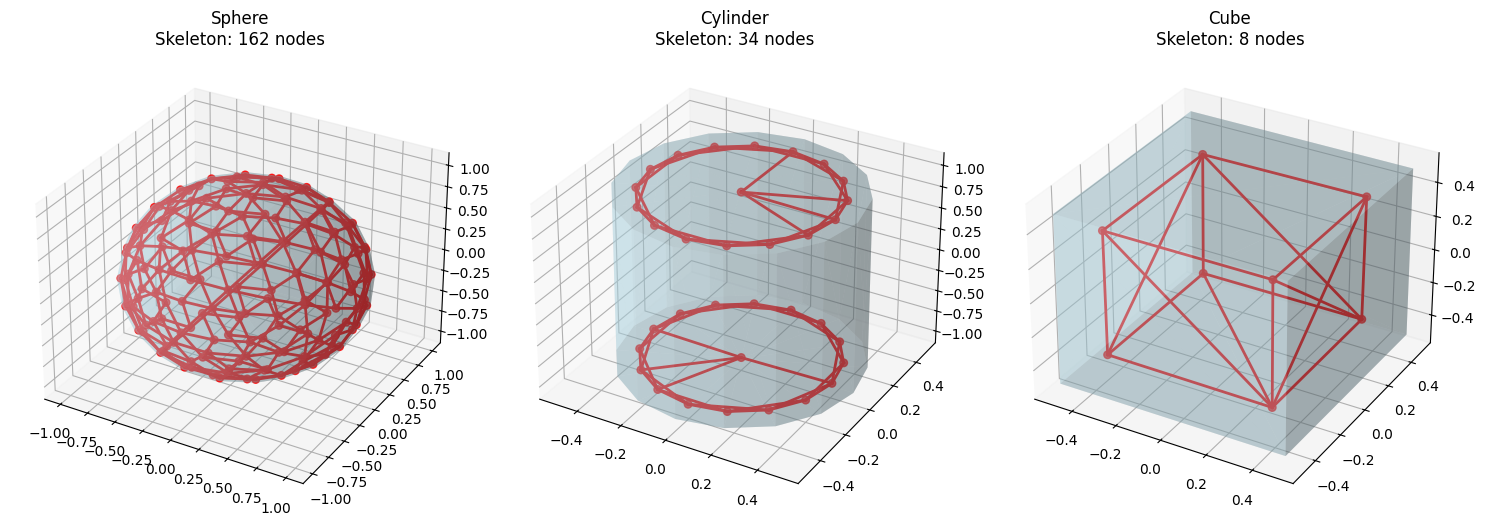

In [10]:
# DEBUG: Test different mesh types for comparison
print("=== Testing Different Mesh Types ===")

def test_mesh_skeletonization(mesh_obj, name):
    print(f"\n--- Testing {name} ---")
    print(f"Original mesh: {mesh_obj.vertices.shape[0]} vertices, {mesh_obj.faces.shape[0]} faces")
    
    # Analyze original mesh
    mm_test = MeshManager(mesh_obj)
    
    # Test skeletonization with adjusted parameters
    skel_test = skeletonize(
        mesh_obj,
        mcf_dt=1e-2,  # Smaller dt for stability
        mcf_iters=30,  # Fewer iterations
        laplacian_type="cotangent",
        guidance_type="original",  # Use guidance to preserve shape
        guidance_weight=0.05,
        build_graph="mesh",
        knn=8,  # Smaller kNN
        collapse_passes=2,
        collapse_mode="percentile",
        collapse_percentile=0.15,  # More aggressive
        preserve_branch_degree=2,  # Allow more collapse
        verbose=False,
    )
    
    print(f"Result: {skel_test.nodes.shape[0]} nodes, {skel_test.edges.shape[0]} edges")
    return skel_test, mesh_obj

# Test different primitive meshes
mesh_sphere = tm.primitives.Sphere(radius=1.0, subdivisions=2)
mesh_cylinder = tm.primitives.Cylinder(radius=0.5, height=2.0, sections=16)
mesh_cube = tm.primitives.Box(extents=[1, 1, 1])

# Run tests
skel_sphere, sphere_mesh = test_mesh_skeletonization(mesh_sphere, "Sphere")
skel_cylinder, cylinder_mesh = test_mesh_skeletonization(mesh_cylinder, "Cylinder") 
skel_cube, cube_mesh = test_mesh_skeletonization(mesh_cube, "Cube")

# Visualize all results
fig = plt.figure(figsize=(15, 10))
meshes_and_skeletons = [
    (sphere_mesh, skel_sphere, "Sphere"),
    (cylinder_mesh, skel_cylinder, "Cylinder"),
    (cube_mesh, skel_cube, "Cube")
]

for i, (mesh_vis, skel_vis, name) in enumerate(meshes_and_skeletons, 1):
    ax = fig.add_subplot(2, 3, i, projection='3d')
    # Plot mesh (semi-transparent)
    ax.plot_trisurf(mesh_vis.vertices[:, 0], mesh_vis.vertices[:, 1], mesh_vis.vertices[:, 2],
                   triangles=mesh_vis.faces, alpha=0.3, color='lightblue')
    # Plot skeleton
    for edge in skel_vis.edges:
        points = skel_vis.nodes[edge]
        ax.plot3D(points[:, 0], points[:, 1], points[:, 2], 'r-', linewidth=2)
    ax.scatter(skel_vis.nodes[:, 0], skel_vis.nodes[:, 1], skel_vis.nodes[:, 2],
              c='red', s=30, alpha=0.8)
    ax.set_title(f'{name}\nSkeleton: {skel_vis.nodes.shape[0]} nodes')

plt.tight_layout()
plt.show()

=== Manual Edge Collapse Analysis ===
Total edges: 768
Shortest 10 edges:
  1: edge [40 41], length = 0.004732
  2: edge [216 223], length = 0.004732
  3: edge [248 249], length = 0.004732
  4: edge [32 33], length = 0.004732
  5: edge [32 39], length = 0.004732
  6: edge [72 79], length = 0.004732
  7: edge [64 71], length = 0.004732
  8: edge [224 225], length = 0.004732
  9: edge [8 9], length = 0.004732
  10: edge [240 241], length = 0.004732

Vertex degree distribution:
  Degree 6: 256 vertices
Threshold 0.010: 0 edges can collapse (out of 768 total)
Threshold 0.020: 0 edges can collapse (out of 768 total)
Threshold 0.050: 0 edges can collapse (out of 768 total)
Threshold 0.100: 0 edges can collapse (out of 768 total)
Threshold 0.200: 0 edges can collapse (out of 768 total)


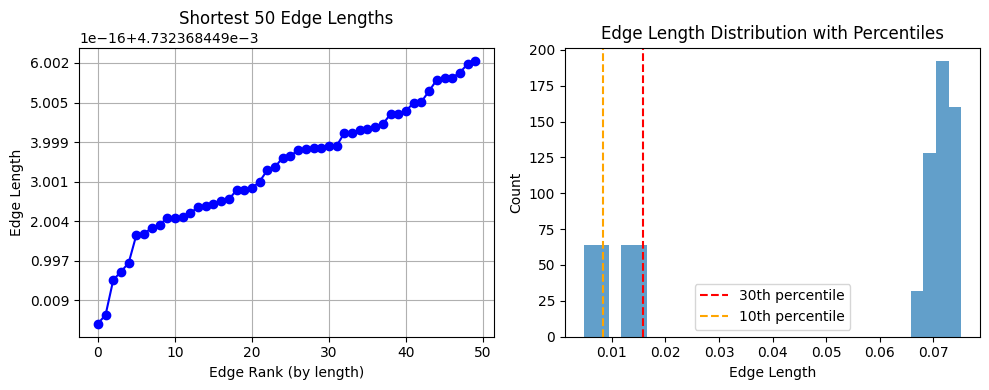

In [11]:
# DEBUG: Manual edge collapse analysis
print("=== Manual Edge Collapse Analysis ===")

# Get contracted mesh
mcf_manual = mean_curvature_flow(
    mesh,
    dt=2e-2,
    iterations=50,
    laplacian_type="cotangent",
    laplacian_secure=True,
)
V_contracted = mcf_manual.vertices
mesh_contracted = tm.Trimesh(vertices=V_contracted, faces=mesh.faces, process=False)

# Build mesh-edge graph manually
edges = mesh_contracted.edges_unique
edge_lengths = np.linalg.norm(V_contracted[edges[:, 0]] - V_contracted[edges[:, 1]], axis=1)

# Sort edges by length
sorted_indices = np.argsort(edge_lengths)
sorted_edges = edges[sorted_indices]
sorted_lengths = edge_lengths[sorted_indices]

print(f"Total edges: {len(edges)}")
print(f"Shortest 10 edges:")
for i in range(min(10, len(sorted_edges))):
    e = sorted_edges[i]
    length = sorted_lengths[i]
    print(f"  {i+1}: edge {e}, length = {length:.6f}")

# Analyze vertex degrees
vertex_degrees = np.zeros(V_contracted.shape[0], dtype=int)
for edge in edges:
    vertex_degrees[edge[0]] += 1
    vertex_degrees[edge[1]] += 1

print(f"\nVertex degree distribution:")
unique_degrees, counts = np.unique(vertex_degrees, return_counts=True)
for deg, count in zip(unique_degrees, counts):
    print(f"  Degree {deg}: {count} vertices")

# Test manual collapse with different thresholds
thresholds = [0.01, 0.02, 0.05, 0.1, 0.2]
for thresh in thresholds:
    collapsible_edges = []
    for i, (edge, length) in enumerate(zip(sorted_edges, sorted_lengths)):
        if length > thresh:
            break
        # Check if either endpoint has high degree (>= 3)
        if vertex_degrees[edge[0]] >= 3 or vertex_degrees[edge[1]] >= 3:
            continue
        collapsible_edges.append(i)
    
    print(f"Threshold {thresh:.3f}: {len(collapsible_edges)} edges can collapse (out of {len(edges)} total)")

# Visualize shortest edges
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(sorted_lengths[:50], 'bo-')
ax1.set_xlabel('Edge Rank (by length)')
ax1.set_ylabel('Edge Length')
ax1.set_title('Shortest 50 Edge Lengths')
ax1.grid(True)

ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(edge_lengths, bins=30, alpha=0.7)
ax2.axvline(x=np.percentile(edge_lengths, 30), color='red', linestyle='--', label='30th percentile')
ax2.axvline(x=np.percentile(edge_lengths, 10), color='orange', linestyle='--', label='10th percentile')
ax2.set_xlabel('Edge Length')
ax2.set_ylabel('Count')
ax2.set_title('Edge Length Distribution with Percentiles')
ax2.legend()

plt.tight_layout()
plt.show()

=== Testing Voronoi Guidance Impact ===
Voronoi analysis: 256 poles computed
Weight stats: min=1.000, max=1.000, mean=1.000

--- Testing No guidance ---
Result: 256 nodes, 864 edges

--- Testing Original guidance (w=0.1) ---
Result: 256 nodes, 960 edges

--- Testing Centroid guidance (w=0.05) ---
Result: 256 nodes, 835 edges

--- Testing Voronoi guidance (w=0.5) ---
Result: 256 nodes, 859 edges


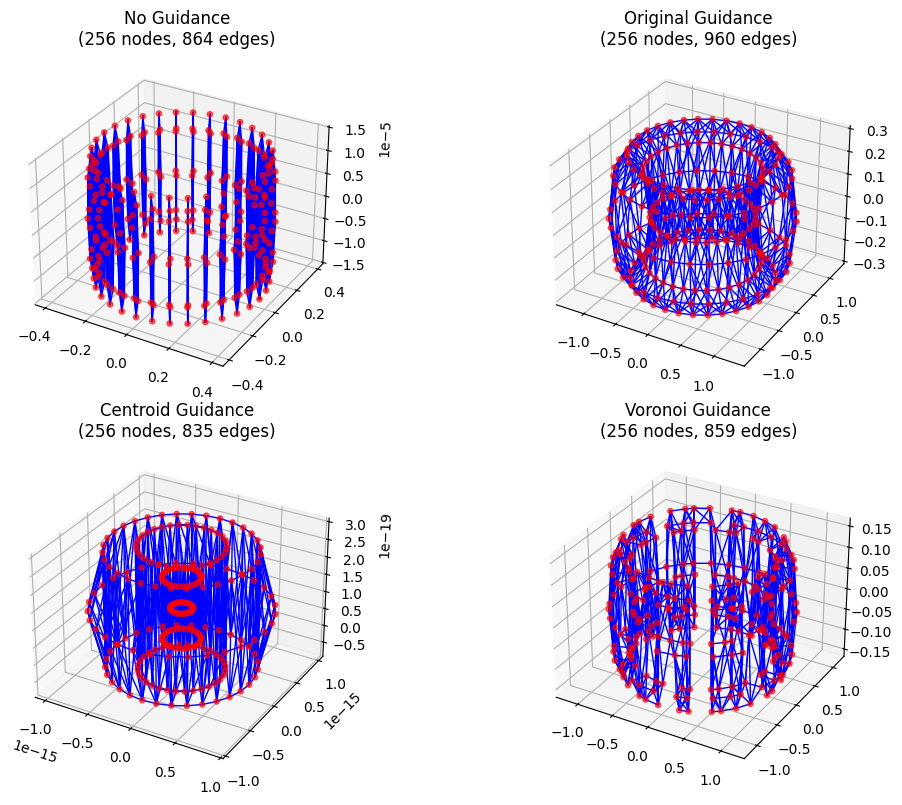

In [12]:
# DEBUG: Test Voronoi guidance impact on skeletonization
print("=== Testing Voronoi Guidance Impact ===")

# Compute Voronoi poles
targets, weights = compute_voronoi_poles(mesh)
print(f"Voronoi analysis: {targets.shape[0]} poles computed")
print(f"Weight stats: min={weights.min():.3f}, max={weights.max():.3f}, mean={weights.mean():.3f}")

# Test skeletonization with different guidance strategies
def test_guidance_strategy(guidance_type, guidance_weight, name):
    print(f"\n--- Testing {name} ---")
    skel_guided = skeletonize(
        mesh,
        mcf_dt=2e-2,
        mcf_iters=50,
        laplacian_type="cotangent",
        guidance_type=guidance_type,
        guidance_weight=guidance_weight,
        build_graph="mesh",
        knn=12,
        collapse_passes=3,
        collapse_mode="percentile",
        collapse_percentile=0.2,  # More aggressive to see differences
        preserve_branch_degree=3,
        medial_protect=(guidance_type == "voronoi"),
        medial_protect_threshold=0.5,
        verbose=False,
    )
    print(f"Result: {skel_guided.nodes.shape[0]} nodes, {skel_guided.edges.shape[0]} edges")
    return skel_guided

# Compare guidance strategies
skel_none = test_guidance_strategy(None, 0.0, "No guidance")
skel_original = test_guidance_strategy("original", 0.1, "Original guidance (w=0.1)")
skel_centroid = test_guidance_strategy("centroid", 0.05, "Centroid guidance (w=0.05)")
skel_voronoi = test_guidance_strategy("voronoi", 0.5, "Voronoi guidance (w=0.5)")

# Visualize comparison
fig = plt.figure(figsize=(12, 8))
results = [
    (skel_none, 'No Guidance'),
    (skel_original, 'Original Guidance'),
    (skel_centroid, 'Centroid Guidance'),
    (skel_voronoi, 'Voronoi Guidance')
]

for i, (skel_result, title) in enumerate(results, 1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    # Plot skeleton
    for edge in skel_result.edges:
        points = skel_result.nodes[edge]
        ax.plot3D(points[:, 0], points[:, 1], points[:, 2], 'b-', linewidth=1)
    ax.scatter(skel_result.nodes[:, 0], skel_result.nodes[:, 1], skel_result.nodes[:, 2], 
              c='red', s=15, alpha=0.6)
    ax.set_title(f'{title}\n({skel_result.nodes.shape[0]} nodes, {skel_result.edges.shape[0]} edges)')

plt.tight_layout()
plt.show()


=== Testing MCF: Mild (dt=0.01, 10 iters) ===
Volume: 1.589180 -> 0.202265 (ratio: 0.127276)
Bounds size: [2.080076, 2.080076, 0.202739]

=== Testing MCF: Moderate (dt=0.02, 25 iters) ===
Volume: 1.589180 -> 0.000677 (ratio: 0.000426)
Bounds size: [1.293409, 1.293409, 0.003526]

=== Testing MCF: Aggressive (dt=0.02, 50 iters) ===
Volume: 1.589180 -> 0.000001 (ratio: 0.000001)
Bounds size: [0.763958, 0.763958, 0.000021]


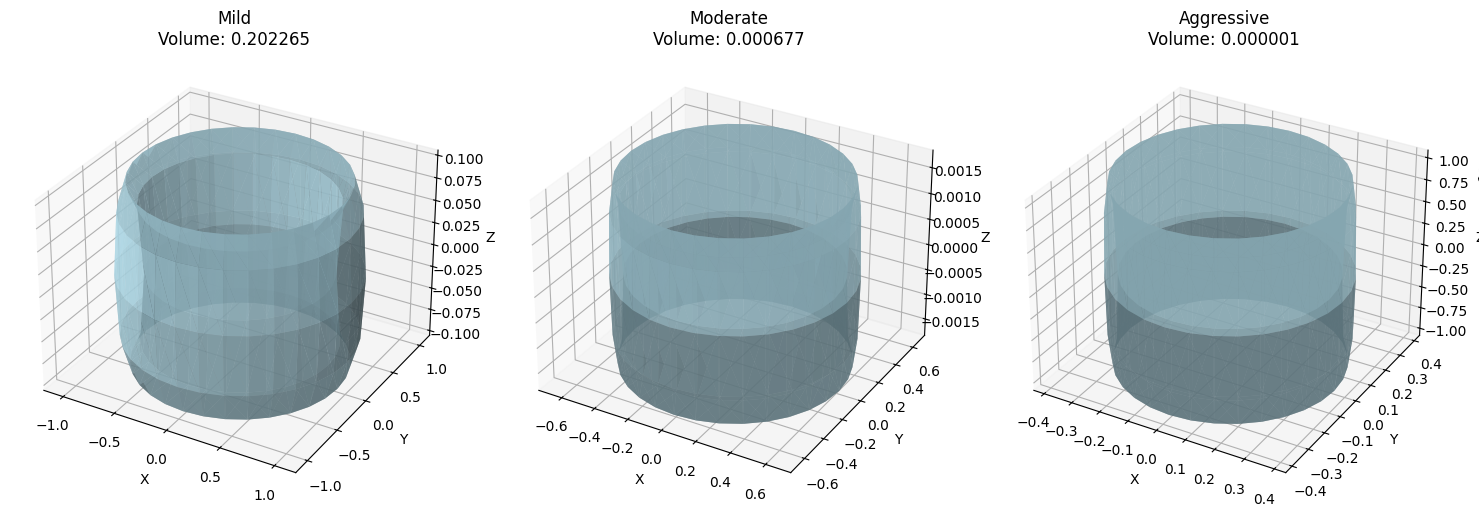

In [13]:
# DEBUG: Test different MCF contraction levels
def test_mcf_contraction(dt, iters, name):
    print(f"\n=== Testing MCF: {name} ===")
    mcf_test = mean_curvature_flow(
        mesh,
        dt=dt,
        iterations=iters,
        laplacian_type="cotangent",
        laplacian_secure=True,
    )
    V_test = mcf_test.vertices
    mesh_test = tm.Trimesh(vertices=V_test, faces=mesh.faces, process=False)
    
    print(f"Volume: {mesh.volume:.6f} -> {mesh_test.volume:.6f} (ratio: {mesh_test.volume/mesh.volume:.6f})")
    
    # Analyze geometry
    bounds = mesh_test.bounds
    size = bounds[1] - bounds[0]
    print(f"Bounds size: [{size[0]:.6f}, {size[1]:.6f}, {size[2]:.6f}]")
    
    return V_test, mesh_test

# Test different contraction levels
V_mild, mesh_mild = test_mcf_contraction(1e-2, 10, "Mild (dt=0.01, 10 iters)")
V_moderate, mesh_moderate = test_mcf_contraction(2e-2, 25, "Moderate (dt=0.02, 25 iters)")
V_aggressive, mesh_aggressive = test_mcf_contraction(2e-2, 50, "Aggressive (dt=0.02, 50 iters)")

# Visualize contraction levels
fig = plt.figure(figsize=(15, 5))
meshes = [(mesh_mild, 'Mild'), (mesh_moderate, 'Moderate'), (mesh_aggressive, 'Aggressive')]

for i, (mesh_vis, title) in enumerate(meshes, 1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    ax.plot_trisurf(mesh_vis.vertices[:, 0], mesh_vis.vertices[:, 1], mesh_vis.vertices[:, 2], 
                   triangles=mesh_vis.faces, alpha=0.7, color='lightblue')
    ax.set_title(f'{title}\nVolume: {mesh_vis.volume:.6f}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

plt.tight_layout()
plt.show()


=== Testing mesh graph ===
Mesh-edge graph: 256 nodes, 768 edges
Edge length range: [0.004732, 0.075210]

=== Testing knn graph ===
kNN graph (k=6): 256 nodes, 864 edges
Edge length range: [0.001024, 0.036487]

=== Testing knn graph ===
kNN graph (k=12): 256 nodes, 1716 edges
Edge length range: [0.001024, 0.074881]

=== Testing knn graph ===
kNN graph (k=20): 256 nodes, 2752 edges
Edge length range: [0.001024, 0.080317]


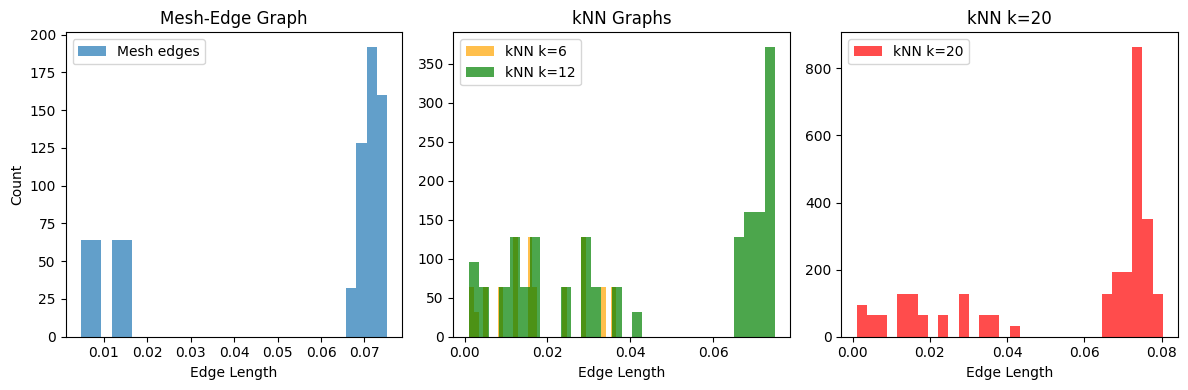

In [14]:
# DEBUG: Test kNN graph construction vs mesh-edge graph (FIXED)
def test_graph_construction(build_graph_type, knn_k=12):
    print(f"\n=== Testing {build_graph_type} graph ===")
    
    # Run MCF first to get contracted points
    mcf_knn = mean_curvature_flow(
        mesh,
        dt=2e-2,
        iterations=50,
        laplacian_type="cotangent",
        laplacian_secure=True,
    )
    V_contracted = mcf_knn.vertices
    
    if build_graph_type == "mesh":
        # Mesh-edge graph
        mesh_contracted = tm.Trimesh(vertices=V_contracted, faces=mesh.faces, process=False)
        edges = mesh_contracted.edges_unique
        edge_lengths = np.linalg.norm(V_contracted[edges[:, 0]] - V_contracted[edges[:, 1]], axis=1)
        print(f"Mesh-edge graph: {V_contracted.shape[0]} nodes, {edges.shape[0]} edges")
        print(f"Edge length range: [{edge_lengths.min():.6f}, {edge_lengths.max():.6f}]")
    else:
        # kNN graph - build manually since _knn_graph is private
        from scipy.spatial import cKDTree
        import networkx as nx
        
        tree = cKDTree(V_contracted)
        G_knn = nx.Graph()
        
        # Add nodes with positions
        for i, point in enumerate(V_contracted):
            G_knn.add_node(i, pos=point)
        
        # Add kNN edges
        for i, point in enumerate(V_contracted):
            distances, indices = tree.query(point, k=knn_k+1)  # +1 to include self
            for j, neighbor_idx in enumerate(indices):
                if neighbor_idx != i:  # Skip self
                    dist = distances[j]
                    if not G_knn.has_edge(i, neighbor_idx):
                        G_knn.add_edge(i, neighbor_idx, weight=dist)
        
        edges_knn = np.array(list(G_knn.edges()))
        node_positions = V_contracted
        edge_lengths = np.linalg.norm(node_positions[edges_knn[:, 0]] - node_positions[edges_knn[:, 1]], axis=1)
        print(f"kNN graph (k={knn_k}): {node_positions.shape[0]} nodes, {edges_knn.shape[0]} edges")
        print(f"Edge length range: [{edge_lengths.min():.6f}, {edge_lengths.max():.6f}]")
    
    return edge_lengths

# Compare graph types
mesh_lengths = test_graph_construction("mesh")
knn_lengths_6 = test_graph_construction("knn", knn_k=6)
knn_lengths_12 = test_graph_construction("knn", knn_k=12)
knn_lengths_20 = test_graph_construction("knn", knn_k=20)

# Plot edge length distributions
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(mesh_lengths, bins=30, alpha=0.7, label='Mesh edges')
plt.xlabel('Edge Length')
plt.ylabel('Count')
plt.title('Mesh-Edge Graph')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(knn_lengths_6, bins=30, alpha=0.7, label='kNN k=6', color='orange')
plt.hist(knn_lengths_12, bins=30, alpha=0.7, label='kNN k=12', color='green')
plt.xlabel('Edge Length')
plt.title('kNN Graphs')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(knn_lengths_20, bins=30, alpha=0.7, label='kNN k=20', color='red')
plt.xlabel('Edge Length')
plt.title('kNN k=20')
plt.legend()

plt.tight_layout()
plt.show()